In [1]:
import os
import pandas as pd
from pathlib import Path
import tarfile
import urllib.request
import matplotlib.pyplot as plt

In [2]:
def load_housing_data():
    # tarball_path = path("datasets/housing.tgz")
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
    

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


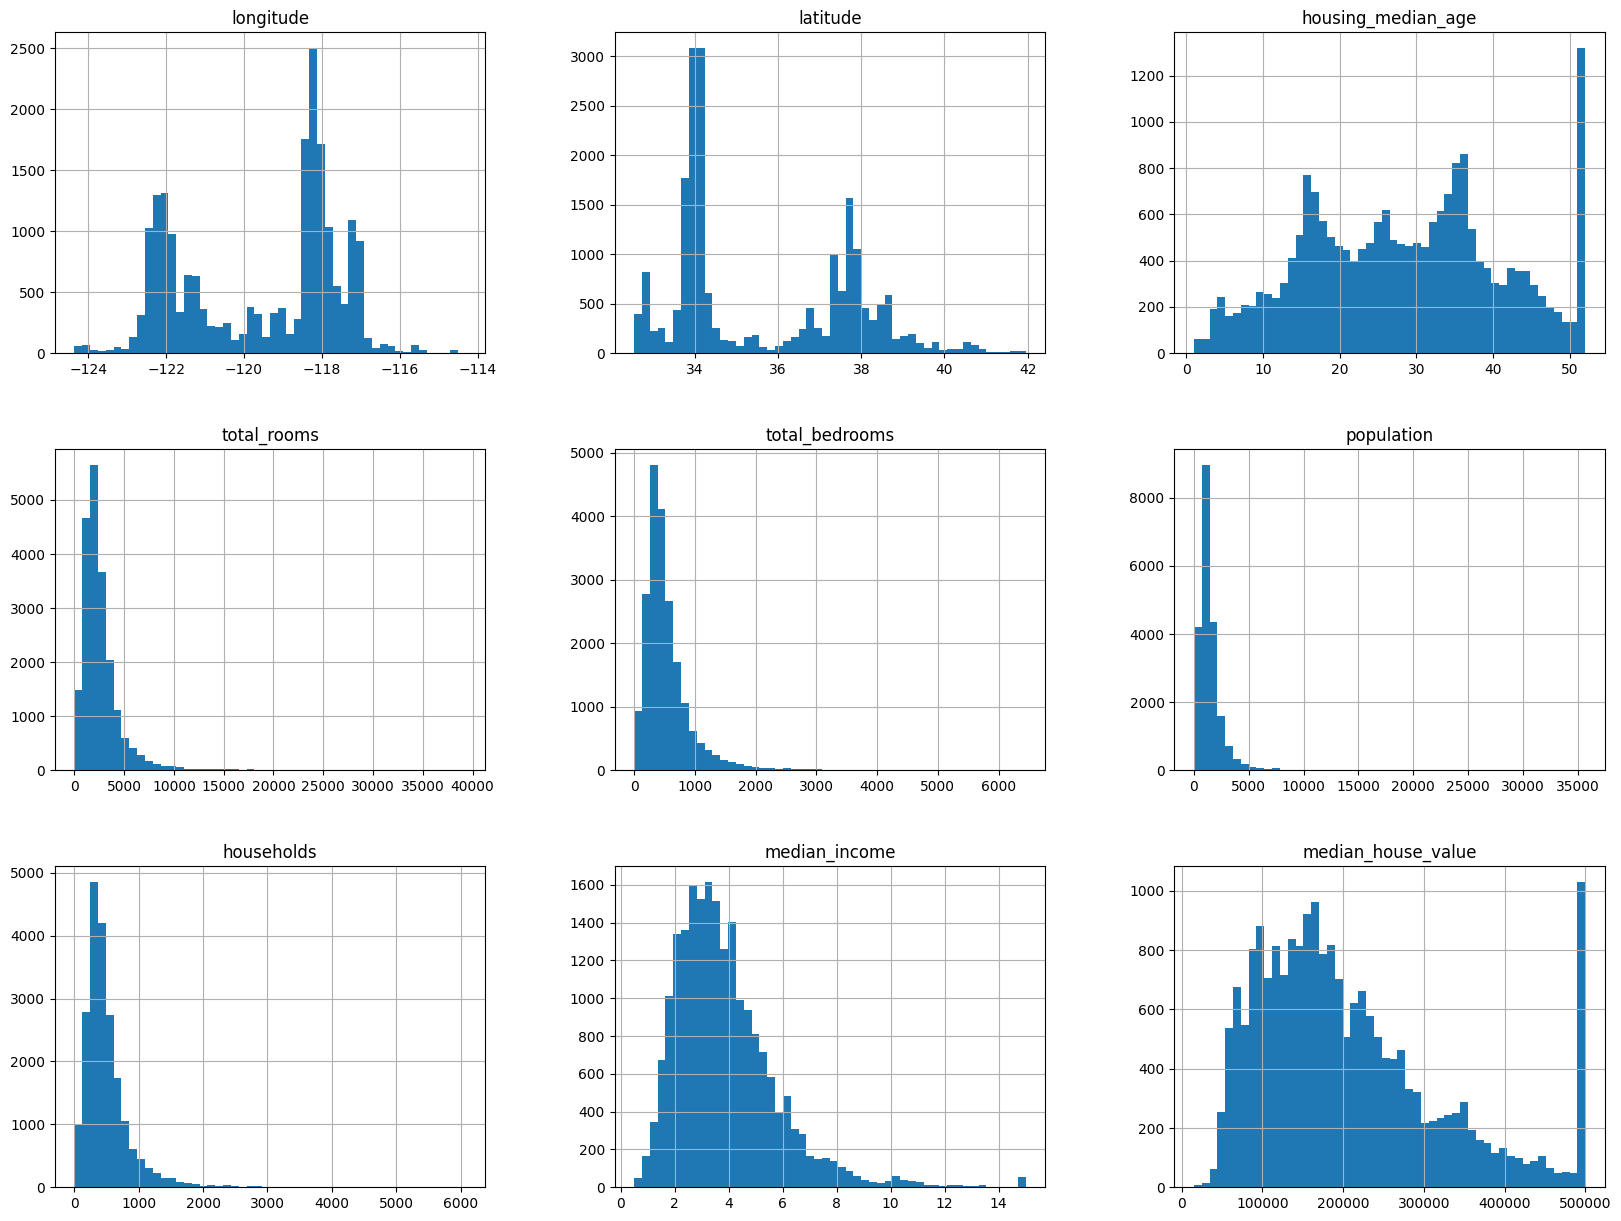

In [7]:

housing.hist(bins = 50, figsize = (20, 15))
plt.show()

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    print("test_set_size = ", test_set_size)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train + ", len(test_set), "test")

test_set_size =  4128
16512 train +  4128 test


In [9]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[-in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()    # adds on 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")


In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [11]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0)       # remove inplace = True, since pandas 3.0 remove this expression

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [12]:
for set in (strat_train_set, strat_test_set):
    if "income_cat" in set.columns:
        set.drop("income_cat", axis=1, inplace=True)

In [13]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

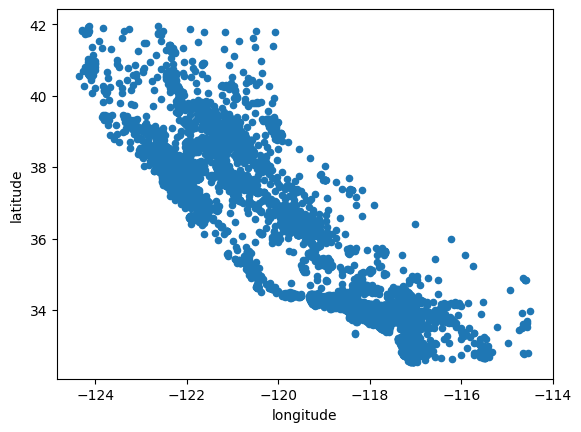

In [14]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

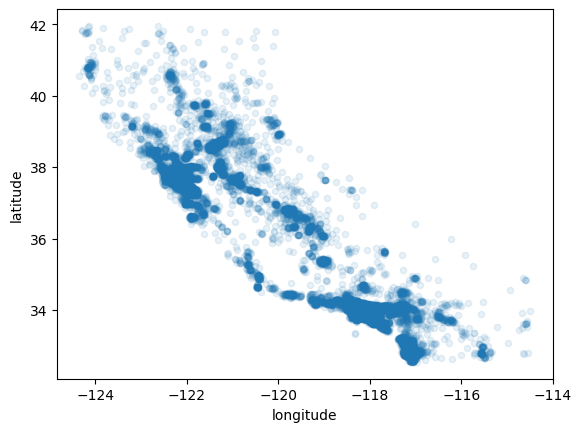

In [15]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)  # better seeing high-density areas

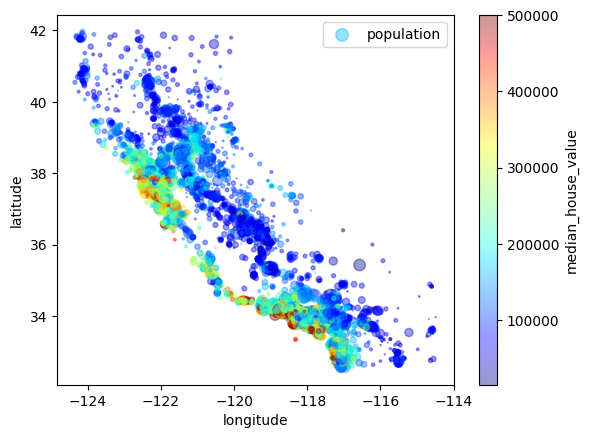

In [16]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
             s = housing["population"]/100, label = "population",
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [17]:
housing_encoded = pd.get_dummies(housing, drop_first = True)
corr_matrix = housing_encoded.corr()
# corr_matrix = housing.drop(columns=["ocean_proximity"]).corr()

print(corr_matrix["median_house_value"].sort_values(ascending = False))

median_house_value            1.000000
median_income                 0.688694
ocean_proximity_NEAR BAY      0.165839
ocean_proximity_NEAR OCEAN    0.139091
total_rooms                   0.138723
housing_median_age            0.104071
households                    0.071477
total_bedrooms                0.054485
ocean_proximity_ISLAND        0.023215
population                   -0.018941
longitude                    -0.049113
latitude                     -0.141289
ocean_proximity_INLAND       -0.485693
Name: median_house_value, dtype: float64


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

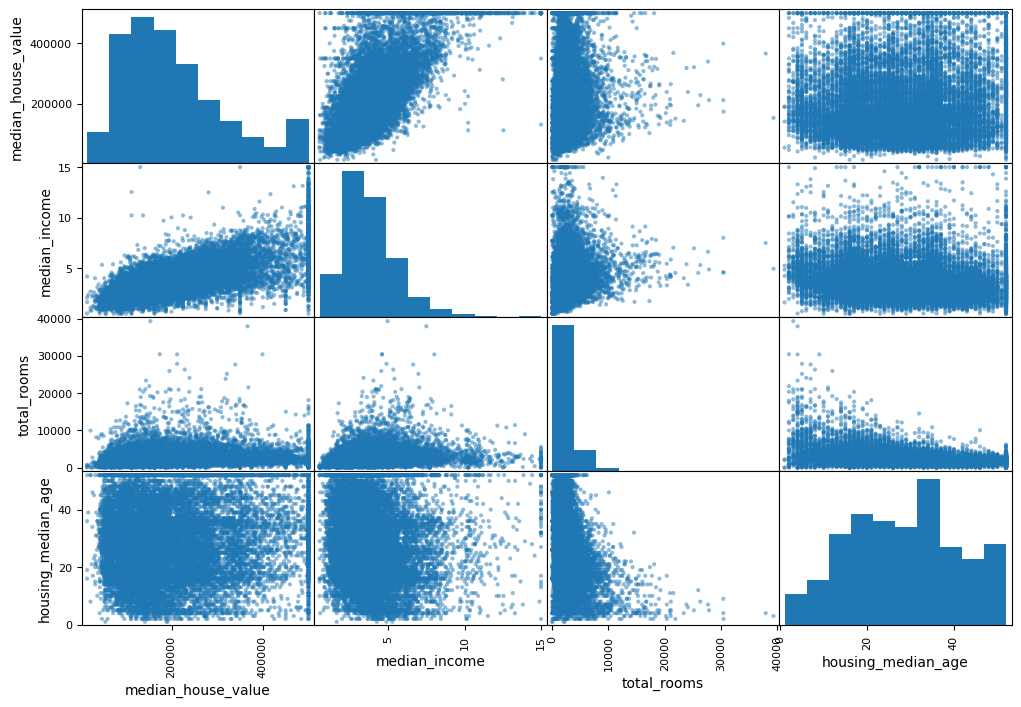

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

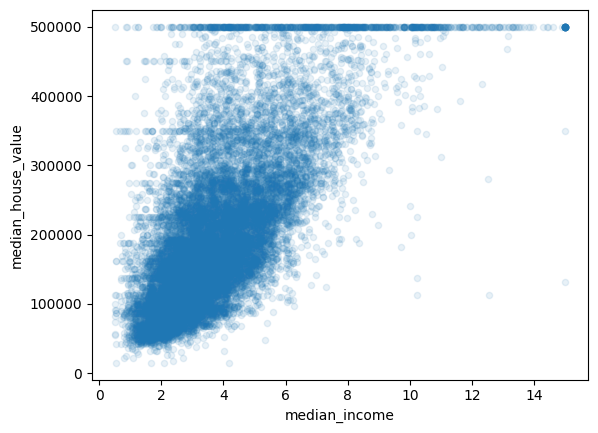

In [19]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

In [20]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# housing_encoded = pd.get_dummies(housing, drop_first = True)
#  corr_matrix = housing_encoded.corr()
corr_matrix = housing.corr(numeric_only = True)
print(corr_matrix["median_house_value"].sort_values(ascending = False))

median_house_value          1.000000
median_income               0.688694
rooms_per_household         0.144783
total_rooms                 0.138723
housing_median_age          0.104071
households                  0.071477
total_bedrooms              0.054485
population                 -0.018941
population_per_household   -0.019829
longitude                  -0.049113
latitude                   -0.141289
bedrooms_per_room          -0.258386
Name: median_house_value, dtype: float64


In [21]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [22]:
print(corr_matrix["median_house_value"].sort_values(ascending = False))

median_house_value          1.000000
median_income               0.688694
rooms_per_household         0.144783
total_rooms                 0.138723
housing_median_age          0.104071
households                  0.071477
total_bedrooms              0.054485
population                 -0.018941
population_per_household   -0.019829
longitude                  -0.049113
latitude                   -0.141289
bedrooms_per_room          -0.258386
Name: median_house_value, dtype: float64


In [23]:
housing.dropna(subset = ["total_bedrooms"])  # Data cleaning option 1
# housing.drop("total_bedrooms", axis = 1)     # option 2
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median)    # optiopn 3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17950,-118.15,34.16,52.0,1925.0,597.0,2258.0,594.0,1.6921,<1H OCEAN
13140,-122.35,37.56,52.0,1659.0,191.0,519.0,201.0,14.4219,NEAR OCEAN
15413,-118.25,33.93,42.0,657.0,147.0,526.0,132.0,2.5000,<1H OCEAN
4371,-120.54,38.07,37.0,736.0,148.0,339.0,140.0,2.2875,INLAND
2921,-117.32,33.17,18.0,2143.0,299.0,828.0,283.0,4.2383,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
5215,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,INLAND
12228,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,NEAR BAY
13741,-121.47,39.49,17.0,1554.0,242.0,553.0,230.0,3.2174,INLAND
10730,-117.68,34.04,27.0,574.0,103.0,321.0,103.0,3.9107,INLAND


In [24]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2125.       433.      1167.
  408.         3.53825]
[-118.51      34.26      29.      2125.       433.      1167.
  408.         3.53825]


In [25]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()     # using encoder to convert text labels to numbers
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)

[0 4 0 ... 1 1 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()   # Convert integer categorical values into One-hot vector
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
print(housing_cat_1hot.toarray())

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [28]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()     # apply both transmations (text to integer and integer to one-hot vector)
housing_cat_1hot = encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

[[1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]]


In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):   # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self    # nothing else to do
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

class DataFrameSelector(BaseEstimator, TransformerMixin):    # need to write a transformer for DataFrame
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [30]:
# transformation pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = "median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()), ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
print(housing_num_tr)

[[ 0.71164756 -0.69275587  1.85881385 ... -0.85661005  0.06869681
   1.46284064]
 [-1.38743863  0.90110721  1.85881385 ...  1.0953777  -0.04598603
  -1.49363634]
 [ 0.66166931 -0.80057602  1.0646138  ... -0.18042902  0.0859569
   0.15311441]
 ...
 [-0.94763009  1.80585889 -0.9208863  ...  0.51238542 -0.06270435
  -0.87812054]
 [ 0.9465453  -0.74900986 -0.12668626 ...  0.05146694  0.00428085
  -0.51856261]
 [-1.39243645  1.12143534  0.27041376 ...  0.159768   -0.03879546
  -0.47935207]]


In [31]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                          ('imputer', SimpleImputer(strategy = "median")),
                          ('sttribs_addr', CombinedAttributesAdder()),
                          ('std_scaler', StandardScaler()), ])

# cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)),
#                          ('label_binarizer', LabelBinarizer()), ])

# full_pipeline = FeatureUnion(transformer_list = [('num_pipeline', num_pipeline),
#                                                 ('cat_pipeline', cat_pipeline), ])

cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])    # use OneHotEncoder and ColumnTransformer to select desired attributes

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)
print("------------------------------------------------------")
print(housing_prepared.shape)

[[ 0.71164756 -0.69275587  1.85881385 ...  0.          0.
   0.        ]
 [-1.38743863  0.90110721  1.85881385 ...  0.          0.
   1.        ]
 [ 0.66166931 -0.80057602  1.0646138  ...  0.          0.
   0.        ]
 ...
 [-0.94763009  1.80585889 -0.9208863  ...  0.          0.
   0.        ]
 [ 0.9465453  -0.74900986 -0.12668626 ...  0.          0.
   0.        ]
 [-1.39243645  1.12143534  0.27041376 ...  0.          1.
   0.        ]]
------------------------------------------------------
(16512, 16)


In [32]:
# Select and Train a Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [139501.14946343 676695.39036596 175808.53535507  85568.23417874
 219361.96859743]
Labels:		 [162500.0, 500001.0, 110200.0, 79900.0, 239000.0]


In [33]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

67913.93520083171


In [34]:
# let's select a more powerful model to reduce the prediction bias
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)         # too good to be true

0.0


In [35]:
# K-fold Cross-Validation way
# calculate scores with the Decision Tree
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [71171.14908975 73827.36610417 73053.51935516 69820.2851181
 74540.35866359 68417.28501158 65623.01480425 69267.29326469
 70056.27899888 70652.08165601]
Mean: 70642.86320661733
Standard deviation: 2539.4280508976653


In [36]:
# compute the same scores for the Linear Regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                                scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71277.92849866 69923.40645265 70241.44110444 65055.21766875
 72466.36722957 65713.97955752 66844.21807597 65017.20855086
 67267.4648578  67027.00534252]
Mean: 68083.42373387408
Standard deviation: 2548.745619900955


In [48]:
# try the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("forest_rmse:", forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                                scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

forest_rmse: 18583.161519152658
Scores: [51701.70587859 54096.4185177  49580.85190207 49099.04196944
 51749.64698372 47310.815377   46837.46633409 48095.06301439
 49182.52327717 51009.9986224 ]
Mean: 49866.35318765556
Standard deviation: 2147.020991670743


In [47]:
# save one model above as my_forest_reg_model to pickle file
import joblib

joblib.dump(forest_reg, "my_forest_reg_model.pkl")
forest_model_loader = joblib.load("my_forest_reg_model.pkl")
print(forest_model_loader.predict(housing_prepared))

[166937. 500001. 108218. ...  99154. 172661. 192619.]


In [54]:
# Fine Tune the models
# Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)

{'max_features': 6, 'n_estimators': 30}


In [57]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)   # we get the best max_features hyperparameter to 6 and n_estimators hyperparameter to 30
                                          # and the RMSE score for this combination is 49640

64441.46501603977 {'max_features': 2, 'n_estimators': 3}
55383.71750220455 {'max_features': 2, 'n_estimators': 10}
52740.33462331861 {'max_features': 2, 'n_estimators': 30}
59010.42694041189 {'max_features': 4, 'n_estimators': 3}
52941.875229017765 {'max_features': 4, 'n_estimators': 10}
49831.51945087919 {'max_features': 4, 'n_estimators': 30}
58871.835315431556 {'max_features': 6, 'n_estimators': 3}
52080.90091647926 {'max_features': 6, 'n_estimators': 10}
49640.684150970854 {'max_features': 6, 'n_estimators': 30}
58518.59561080275 {'max_features': 8, 'n_estimators': 3}
51798.68004591629 {'max_features': 8, 'n_estimators': 10}
49781.52197411724 {'max_features': 8, 'n_estimators': 30}
62001.04669772148 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53763.048253881025 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59001.81847203719 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52400.14373721499 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [58]:
# Analyze the Best Models and their Errors
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

[7.93815041e-02 7.14251091e-02 4.20413756e-02 1.74567028e-02
 1.67866861e-02 1.89817531e-02 1.55498809e-02 3.21822208e-01
 5.58205376e-02 1.04702944e-01 8.69611373e-02 1.01485851e-02
 1.50383577e-01 1.80566178e-04 3.58993908e-03 4.76749485e-03]


In [97]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted_attributes = sorted(zip(feature_importances, attributes), reverse = True)

# clean the data and print them formatted
cleaned_sorted_attributes = [(float(val), str(name)) for val, name in sorted_attributes]
formatted = "[" + ",\n".join(f" {pair}" for pair in cleaned_sorted_attributes) + "]"
print(formatted)

[ (0.3218222078883891, 'median_income'),
 (0.15038357671462727, 'INLAND'),
 (0.10470294357804501, 'pop_per_hhold'),
 (0.0869611373315807, 'bedrooms_per_room'),
 (0.07938150413141086, 'longitude'),
 (0.07142510905689002, 'latitude'),
 (0.05582053755289158, 'rooms_per_hhold'),
 (0.04204137561488871, 'housing_median_age'),
 (0.018981753110624167, 'population'),
 (0.017456702760980217, 'total_rooms'),
 (0.016786686094459213, 'total_bedrooms'),
 (0.015549880918664664, 'households'),
 (0.010148585135098882, '<1H OCEAN'),
 (0.004767494849571226, 'NEAR OCEAN'),
 (0.003589939084197445, 'NEAR BAY'),
 (0.00018056617768103393, 'ISLAND')]


In [93]:
# evaluate the previous models on the Test Set
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis = 1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)    # => evaluates to 49349.60679198514

49349.60679198514
